# Cross-Validation plots (Figure 4)

## Before you start

This notebook assumes that the cross-validation analyses, up to and including `evaluate_errors.sh` has already been run. Please refer to the `cross_validation` pipeline located in `scripts/cross_validation`.

Verify that `datasets/gibson/cross_validation` has the evaluated metrics stored in `absolute_cv.tsv` and `relative_cv.tsv`, which can run off of the outputs found on Zenodo: [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.8006854.svg)](https://doi.org/10.5281/zenodo.8006854)

The data are expected to be located in the directory `../datasets/gibson/cross_validation`.

In [1]:
from typing import *
from pathlib import Path
import numpy as np
import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import itertools

import scipy.stats
from statsmodels.stats.multitest import fdrcorrection

from matplotlib.patches import Patch
import matplotlib.transforms as mtransforms
import string

# Make font editable in AI
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
def annot_pvalue(ax, pvalue, x1, x2, y, h, color='black', log_scale=False, text_label=None):
    # statistical annotation
    grid_x = np.array([x1, x1, x2, x2])
    grid_y = np.array([0.5*h, 1.5*h, 1.5*h, 0.5*h])
    if log_scale:
        grid_y = np.exp(np.log10(y) + grid_y)
    else:
        grid_y = y + grid_y
    ax.plot(grid_x, grid_y, lw=0.7, c=color)
    
    if text_label is not None:
        text_x = 0.5 * (x1 + x2)
        # text_y = grid_y[0]
        if log_scale:
            text_y = np.exp(np.log10(y) + 1.5 * h)
        else:
            text_y = y + 0.8 * h
        t = ax.text(
            text_x, text_y, text_label, ha='center', va='bottom', color=color, size=5.
        )


def make_boxplot(ax, 
                 df: pd.DataFrame,
                 method_order: List[str],
                 method_labels: Dict[str, str],
                 method_colors: Dict[str, np.ndarray],
                 lb: float,
                 xlabel: Optional[str] = None,
                 ylabel: Optional[str] = None,
                 eps: float = 0.0):
    def agg_fn(_df):
        _df = _df.loc[_df['Truth'] > lb]
        truth = _df['Truth'].to_numpy() + eps
        pred = _df['Pred'].to_numpy() + eps

        err = np.sqrt(np.mean(np.square(
            np.log10(pred) - np.log10(truth)
        )))  # Root mean squared?
        return pd.Series({'Error': err}, index=['Error'])

    df = df.loc[df['Truth'] > lb, :]
    df = df.groupby(['Method', 'HeldoutSubjectIdx', 'TaxonIdx']).apply(agg_fn).reset_index()
    df = df.loc[
        df['Method'].isin(method_order)
    ].sort_values(
        by='Method',
        key=lambda col: col.map({m: i for i, m in enumerate(method_order)})
    )

    sns.boxplot(
        data=df,
        ax=ax,
        x='Method',
        y='Error',
        showfliers=False,
        palette=method_colors,
        whis=(2.5, 97.5)
    )

    labels = [
        method_labels[item.get_text()]
        for item in ax.get_xticklabels()
    ]
    ax.set_xticklabels(labels, rotation=45, ha='right')

    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    
    # ====================== P-value annotations =========================
    entries = []
    for (x1, m1), (x2, m2) in itertools.combinations(enumerate(method_order), 2):
        if not m1.startswith("MDSINE") and not m2.startswith("MDSINE"):
            continue
        _x = df.loc[df['Method'] == m1, :].sort_values(by=['HeldoutSubjectIdx', 'TaxonIdx'])['Error'].to_numpy()
        _y = df.loc[df['Method'] == m2, :].sort_values(by=['HeldoutSubjectIdx', 'TaxonIdx'])['Error'].to_numpy()
        _k = (~np.isnan(_x)) & (~np.isnan(_y))
        _x = _x[_k]
        _y = _y[_k]
        _stat, _pval = scipy.stats.wilcoxon(_x, _y, alternative='two-sided')
        entries.append({
            'Method1': m1,
            'Method2': m2,
            'x1': x1,
            'x2': x2,
            'p': _pval
        })
    pval_df = pd.DataFrame(entries)

    y_annot = np.quantile(df.dropna()['Error'], q=0.99)
    _, bh_pvals = fdrcorrection(pval_df['p'])
    pval_df['bh'] = bh_pvals
    
    # ==== p-value annotation render.
    j = 0
    for idx, row in pval_df.iterrows():
        if row['bh'] > 0.05:
            c = '#FA8072'
            lbl = 'ns'
        elif row['bh'] > 0.01:
            c = 'black'
            lbl = '*'
        elif row['bh'] > 0.001:
            c = 'black'
            lbl = '**'
        elif row['bh'] > 0.0001:
            c = 'black'
            lbl = '***'
        else:
            c = 'black'
            lbl = '****'
        annot_pvalue(ax, row['bh'], x1=row['x1'], x2=row['x2'], y=y_annot + 0.2 * (j), h=0.05, color=c, text_label=lbl)    
        j += 1
    
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, 'major', linewidth=1, color='#e6e6e6')
    


def make_grouped_boxplot(bin_ax, error_ax,
                         df,
                         method_order: List[str],
                         method_labels: Dict[str, str],
                         method_colors: Dict[str, np.ndarray],
                         lb: float,
                         num_bins: int = 10,
                         error_ylabel: Optional[str] = None,
                         eps: float = 0.0,
                         bin_xlabel: str = 'concentration'):
    def agg_fn(_df):
        truth = _df['Truth'].to_numpy() + eps
        pred = _df['Pred'].to_numpy() + eps

        err = np.sqrt(np.mean(np.square(
            np.log10(pred) - np.log10(truth)
        )))  # Root mean squared?
        
        _method = _df.head(1)['Method'].item()
        if np.isnan(err.item()):
            raise Exception("ASDF")
        return pd.Series({'Error': err}, index=['Error'])

    df = df.loc[df['Truth'] > lb]
    df = df.assign(Bin=pd.qcut(
        np.log10(df['Truth']),
        q=num_bins,
        duplicates='drop'
    ))
    df_agg = df.groupby(['Method', 'HeldoutSubjectIdx', 'TaxonIdx', 'Bin']).apply(agg_fn).reset_index()
    

    # ============ Render bin counts.
    def _aggregate_abundances_bin(_df):
        _bin = _df.head(1)['Bin'].item()
        count = sum(1 for _ in _df.groupby(['HeldoutSubjectIdx', 'TaxonIdx', 'TimePoint']))
        return pd.Series({
            'Left': _bin.left,
            'Right': _bin.right,
            'Count': count
        })
    bin_counts = df.groupby('Bin').apply(_aggregate_abundances_bin)
    widths = bin_counts['Right'] - bin_counts['Left']
    
    xmin = bin_counts['Left'].min()
    xmax = bin_counts['Right'].max()
    y = 0.0
    h = 0.5
    r = 0.7 * (2 * h)
    eps = 0.01
    
    bin_ax.set_xlim([xmin-eps, xmax+eps])
    bin_ax.set_ylim([y-h, y+h])
    boundaries = set()
    bin_indices = {}
    
    for b_idx, (_, row) in enumerate(bin_counts.iterrows()):
        x1 = row['Left']
        x2 = row['Right']
        boundaries.add(x1)
        boundaries.add(x2)
        bin_indices[x1] = b_idx
        
        xm = 0.5 * (x1 + x2)
        bin_ax.plot([x1, x2], [y, y], label='', color='black', linewidth=1.0, zorder=0)
        bin_ax.plot([x1, x1], [y - h, y + h], label='', color='black', linewidth=1.0, zorder=0)
        bin_ax.text(xm, y, f'{b_idx + 1}', ha='center', va='center', zorder=2, color='black', fontsize=8)
        
        x1 = row['Left']
        x2 = row['Right']
        xm = 0.5 * (x1 + x2)
        
        # calculate the aspect ratio
        xscale, yscale = bin_ax.transData.transform([1, 1]) - bin_ax.transData.transform([0, 0])
        
        radius_y = r
        radius_x = radius_y * yscale / xscale
        bin_ax.add_patch(patches.Ellipse((xm, y), radius_x, radius_y, color='white', alpha=1.0, zorder=1, linewidth=0.8, ec='black'))
    bin_ax.plot([xmax, xmax], [y - h, y + h], label='', color='black', linewidth=1.0, zorder=0)
    
    def sci_format(x):
        x = np.power(10, x)
        a, b = '{:.2E}'.format(x).split('E')
        return r'{:.1f}$ \times 10^{{{:1d}}}$'.format(float(a), int(b))
    
    boundaries = sorted(boundaries)
    bin_ax.set_yticks([])
    bin_ax.set_xticks(boundaries)
    bin_ax.set_xticklabels([sci_format(b) for b in boundaries], rotation=45, ha='right')
    bin_ax.set_xlabel(bin_xlabel)
    bin_ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    bin_ax.tick_params(length=0)
    
    
    # ============= Render RMSE.
    def _bin_label(interval):
        b_idx = bin_indices[interval.left]
        return f'{b_idx + 1}'
    df_agg['BinLabel'] = df_agg['Bin'].map(_bin_label)
    df_agg = df_agg.sort_values('Bin')
    supported_methods = set(pd.unique(df_agg['Method']))
    method_order = [m for m in method_order if m in supported_methods]
    sns.boxplot(
        data=df_agg,
        ax=error_ax,
        x='BinLabel',
        y='Error',
        hue='Method', hue_order=method_order, palette=method_colors,
        showfliers=False,
        whis=(2.5, 97.5)
    )
    error_ax.set_axisbelow(True)
    error_ax.yaxis.grid(True, 'major', linewidth=1, color='#e6e6e6')
    error_ax.set_xlabel('Bin number')
    if error_ylabel is not None:
        error_ax.set_ylabel(error_ylabel)

    error_ax.get_legend().remove()
    
    # ============= Render PValues.
    bins = sorted(pd.unique(df_agg['Bin']))
    for bin_idx, _bin in enumerate(bins):
        bin_section = df_agg.loc[df_agg['Bin'] == _bin]

        # Compute p-values for each bin
        df_entries = []
        for (i1, m1), (i2, m2) in itertools.combinations(enumerate(method_order), 2):
            if not m1.startswith("MDSINE") and not m2.startswith("MDSINE"):
                continue
            _x = bin_section.loc[bin_section['Method'] == m1, :].sort_values(by=['HeldoutSubjectIdx', 'TaxonIdx'])['Error'].to_numpy()
            _y = bin_section.loc[bin_section['Method'] == m2, :].sort_values(by=['HeldoutSubjectIdx', 'TaxonIdx'])['Error'].to_numpy()
            _k = (~np.isnan(_x)) & (~np.isnan(_y))
            _x = _x[_k]
            _y = _y[_k]
            _stat, _pval = scipy.stats.wilcoxon(_x, _y, alternative='two-sided')
            df_entries.append({
                'Method1': m1,
                'Method2': m2,
                'i1': i1,
                'i2': i2,
                'p': _pval
            })
        pval_df = pd.DataFrame(df_entries)
        
        # ==== Dataframe with p-values (BH correction)
        y_annot = np.quantile(bin_section.dropna()['Error'], q=0.99)
        _, bh_pvals = fdrcorrection(pval_df['p'])
        pval_df['bh'] = bh_pvals
        
        # ==== p-value annotation render.
        j = 0
        box_width = 0.8 / len(method_order)
        left_x = bin_idx - 0.4
        for idx, row in pval_df.iterrows():
            if row['bh'] > 0.05:
                c = '#FA8072'
                lbl = 'ns'
            elif row['bh'] > 0.01:
                c = 'black'
                lbl = '*'
            elif row['bh'] > 0.001:
                c = 'black'
                lbl = '**'
            elif row['bh'] > 0.0001:
                c = 'black'
                lbl = '***'
            else:
                c = 'black'
                lbl = '****'
                
            x1 = left_x + (0.5 * box_width) + (row['i1'] * box_width)
            x2 = left_x + (0.5 * box_width) + (row['i2'] * box_width)
            annot_pvalue(error_ax, row['bh'], x1=x1, x2=x2, y=y_annot + 0.2 * (j), h=0.05, color=c, text_label=lbl)    
            j += 1

def make_zeros_geometricmean_boxplot(ax,
                        df,
                        method_order: List[str],
                        method_labels: Dict[str, str],
                        method_colors: Dict[str, np.ndarray],
                        lb: float,
                        num_bins: int = 10,
                        error_ylabel: Optional[str] = None,
                        eps: float = 0.0,
                        annot_dy: float = 0.5,
                        annot_h: float = 0.5):
    def agg_fn(_df):
        truth = _df['Truth'].to_numpy() + eps
        pred = _df['Pred'].to_numpy() + eps
        
        # == geometric mean
        err = np.mean(np.log10(pred))
        return pd.Series({'Error': err}, index=['Error'])

    df = df.loc[df['Truth'] < lb]
    df_agg = df.groupby(['Method', 'HeldoutSubjectIdx', 'TaxonIdx']).apply(agg_fn).reset_index()
    supported_methods = set(pd.unique(df_agg['Method']))
    method_order = [m for m in method_order if m in supported_methods]
    df_agg = df_agg.loc[
        df_agg['Method'].isin(method_order)
    ].sort_values(
        by='Method',
        key=lambda col: col.map({m: i for i, m in enumerate(method_order)})
    )

    # ============= Render RMSE.
    sns.boxplot(
        data=df_agg,
        x='Method',
        ax=ax,
        y='Error',
        palette=method_colors,
        showfliers=False,
        whis=(2.5, 97.5)
    )
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, 'major', linewidth=1, color='#e6e6e6')
    ax.set_xlabel('')
    if error_ylabel is not None:
        ax.set_ylabel(error_ylabel)

    labels = [
        method_labels[item.get_text()]
        for item in ax.get_xticklabels()
    ]
    ax.set_xticklabels(labels)

## Load metrics

In [3]:
base_dir = Path('../datasets/gibson/cross_validation')
abs_df = pd.read_csv(base_dir / "absolute_cv.tsv", sep='\t')
rel_df = pd.read_csv(base_dir / "relative_cv.tsv", sep='\t')

# Absolute abundance metrics

/tmp/ipykernel_577562/627135987.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


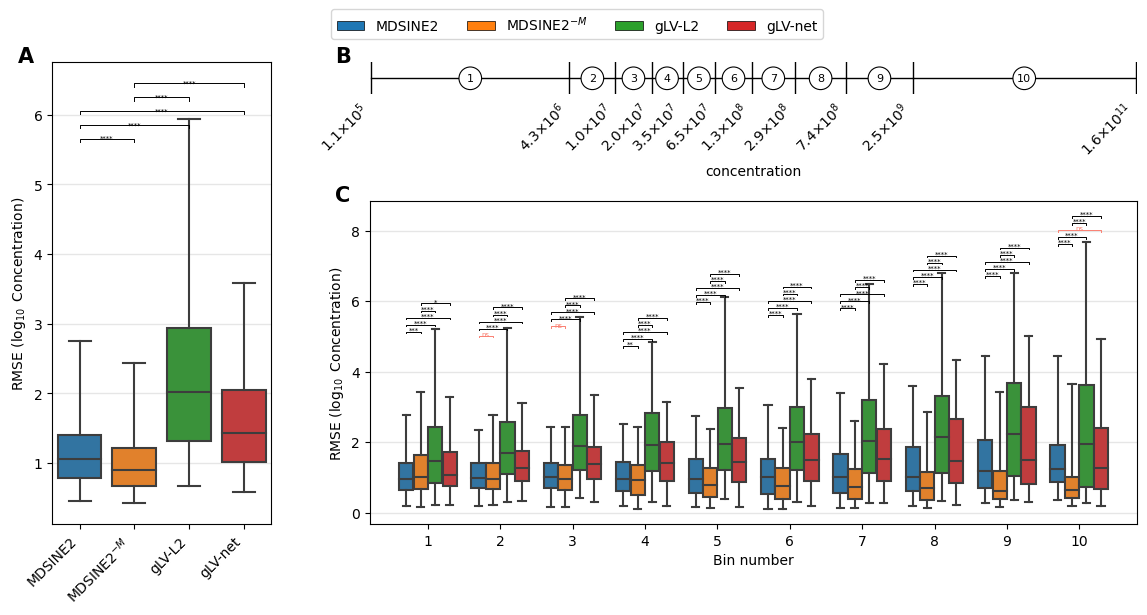

In [4]:
method_order = ['MDSINE2', 'MDSINE2 (No Modules)', 'gLV (ridge)', 'gLV (elastic net)']
method_labels = {
    'MDSINE2': 'MDSINE2', 
    'MDSINE2 (No Modules)': r'MDSINE$2^{-M}$',
    'cLV': 'cLV', 
    'gLV-RA (ridge)': 'RA-gLV-L2', 
    'gLV-RA (elastic net)': 'RA-gLV-net',
    'gLV (elastic net)': 'gLV-net', 
    'gLV (ridge)': 'gLV-L2', 
    'LRA': 'RA-L'
}
palette_tab20 = sns.color_palette("tab10", len(method_order))
method_colors = {m: palette_tab20[i] for i, m in enumerate(method_order)}


fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(2, 2, width_ratios=[1, 3.5], height_ratios=[1, 10], hspace=0.6)
ax = [
    fig.add_subplot(gs[:, 0]),  # unbinned plot
    fig.add_subplot(gs[0, 1:]),  # quantiles
    fig.add_subplot(gs[1, 1:]),  # binned nonzeroes
]

for n, _ax in enumerate(ax):
    trans = mtransforms.ScaledTranslation(-25/72, -3/72, fig.dpi_scale_trans)
    _ax.text(0, 1, string.ascii_uppercase[n], transform=_ax.transAxes + trans,
             va='bottom', fontfamily='sans-serif', weight='bold', size=15)

num_bins = 10
lb = 1e-5
ub = 1e40
make_boxplot(ax[0], abs_df, method_order, method_labels, method_colors, xlabel='', ylabel=r'RMSE ($\log_{10}$ Concentration)', lb=lb)
make_grouped_boxplot(ax[1], ax[2], abs_df, method_order, method_labels, method_colors, num_bins=num_bins, error_ylabel='RMSE ($\log_{10}$ Concentration)', lb=lb)

legend_elements = [
    Patch(facecolor=method_colors[_m], edgecolor='black', label=method_labels[_m], linewidth=0.5)
    for _m in method_order
]
fig.legend(handles=legend_elements, ncol=4, bbox_to_anchor=(0.5, 0.98), loc='upper center')

fig.tight_layout()

# Relative abundance metrics

/tmp/ipykernel_577562/2994228637.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


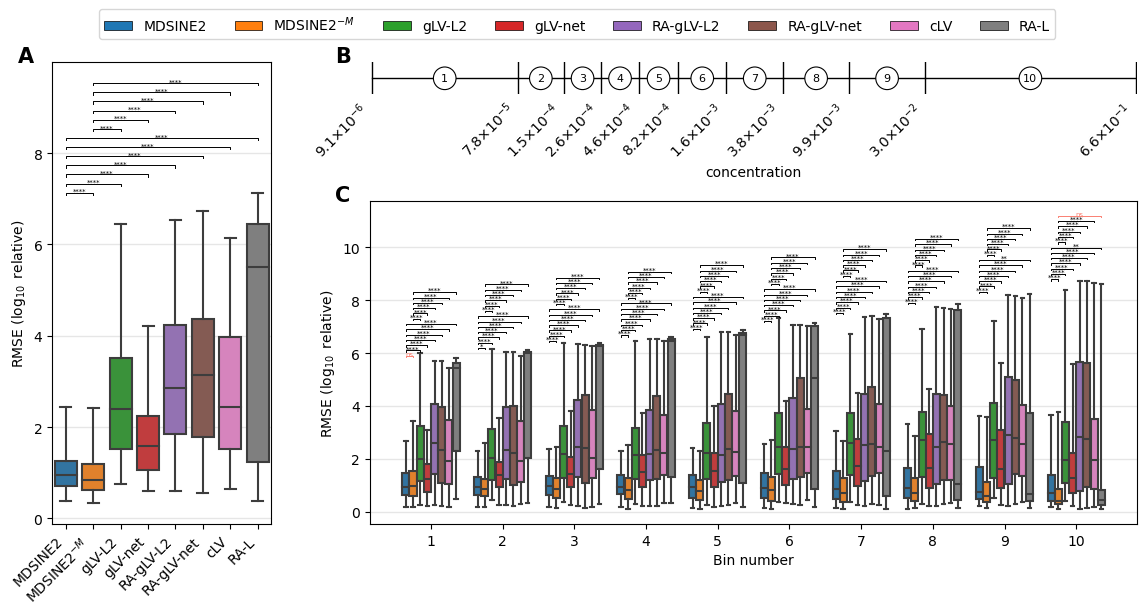

In [5]:
method_order = ['MDSINE2', 'MDSINE2 (No Modules)', 'gLV (ridge)', 'gLV (elastic net)', 'gLV-RA (ridge)', 'gLV-RA (elastic net)', 'cLV', 'LRA']
method_labels = {
    'MDSINE2': 'MDSINE2', 
    'MDSINE2 (No Modules)': r'MDSINE$2^{-M}$',
    'cLV': 'cLV', 
    'gLV-RA (ridge)': 'RA-gLV-L2', 
    'gLV-RA (elastic net)': 'RA-gLV-net',
    'gLV (elastic net)': 'gLV-net', 
    'gLV (ridge)': 'gLV-L2', 
    'LRA': 'RA-L'
}
palette_tab20 = sns.color_palette("tab10", len(method_order))
method_colors = {m: palette_tab20[i] for i, m in enumerate(method_order)}


fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(2, 2, width_ratios=[1, 3.5], height_ratios=[1, 10], hspace=0.6)
ax = [
    fig.add_subplot(gs[:, 0]),  # unbinned plot
    fig.add_subplot(gs[0, 1:]),  # quantiles
    fig.add_subplot(gs[1, 1:]),  # binned nonzeroes
]

# =========== add A/B/C/D labels
for n, _ax in enumerate(ax):
    trans = mtransforms.ScaledTranslation(-25/72, -3/72, fig.dpi_scale_trans)
    _ax.text(0, 1, string.ascii_uppercase[n], transform=_ax.transAxes + trans,
             va='bottom', fontfamily='sans-serif', weight='bold', size=15)

num_bins = 10
lb = 1e-10
ub = 1.
make_boxplot(ax[0], rel_df, method_order, method_labels, method_colors, 
             xlabel='', ylabel='RMSE ($\log_{10}$ relative)', lb=lb, eps=1e-30)
make_grouped_boxplot(ax[1], ax[2], rel_df, method_order, method_labels, method_colors, 
                     num_bins=num_bins, error_ylabel='RMSE ($\log_{10}$ relative)', lb=lb, eps=1e-30)

legend_elements = [
    Patch(facecolor=method_colors[_m], edgecolor='black', label=method_labels[_m], linewidth=0.5)
    for _m in method_order
]
fig.legend(handles=legend_elements, ncol=8, bbox_to_anchor=(0.5, 0.98), loc='upper center')

plt.tight_layout()

# Zero-abundance bin prediction (Supp. Figure)

Errors specific for taxa whose abundances are below a threshold (1e-5 for absolute abund, 1e-10 for relative abund)

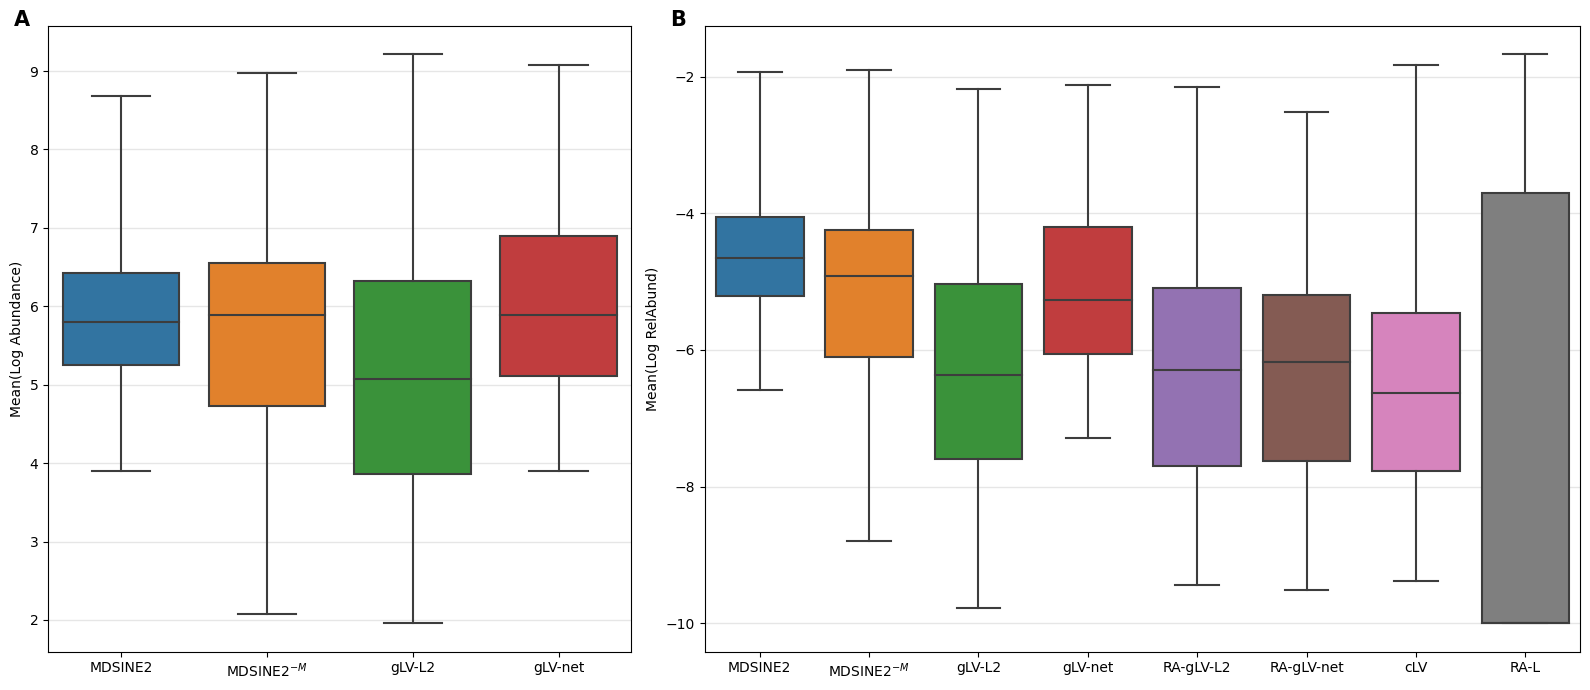

In [6]:
from matplotlib.patches import Patch
import matplotlib.transforms as mtransforms
import string

method_order = ['MDSINE2', 'MDSINE2 (No Modules)', 'gLV (ridge)', 'gLV (elastic net)', 'gLV-RA (ridge)', 'gLV-RA (elastic net)', 'cLV', 'LRA']
method_labels = {
    'MDSINE2': 'MDSINE2', 
    'MDSINE2 (No Modules)': r'MDSINE$2^{-M}$',
    'cLV': 'cLV', 
    'gLV-RA (ridge)': 'RA-gLV-L2', 
    'gLV-RA (elastic net)': 'RA-gLV-net',
    'gLV (elastic net)': 'gLV-net', 
    'gLV (ridge)': 'gLV-L2', 
    'LRA': 'RA-L'
}
palette_tab20 = sns.color_palette("tab10", len(method_order))
method_colors = {m: palette_tab20[i] for i, m in enumerate(method_order)}



fig, ax = plt.subplots(1, 2, figsize=(16, 7), gridspec_kw={'width_ratios': [2, 3]})

method_order = ['MDSINE2', 'MDSINE2 (No Modules)', 'gLV (ridge)', 'gLV (elastic net)']
make_zeros_geometricmean_boxplot(ax[0], abs_df, method_order, method_labels, method_colors, error_ylabel='Mean(Log Abundance)', lb=1e-5, eps=0., annot_dy=0.8, annot_h=0.3)

method_order = ['MDSINE2', 'MDSINE2 (No Modules)', 'gLV (ridge)', 'gLV (elastic net)', 'gLV-RA (ridge)', 'gLV-RA (elastic net)', 'cLV', 'LRA']
make_zeros_geometricmean_boxplot(ax[1], rel_df, method_order, method_labels, method_colors, error_ylabel='Mean(Log RelAbund)', lb=1e-10, eps=1e-30, annot_dy=1., annot_h=0.5)

# =========== add A/B/C/D labels
for n, _ax in enumerate(ax):
    # _ax.text(-.1, 1.1, string.ascii_uppercase[n], transform=_ax.transAxes, size=20, weight='bold')
    trans = mtransforms.ScaledTranslation(-25/72, -3/72, fig.dpi_scale_trans)
    _ax.text(0, 1, string.ascii_uppercase[n], transform=_ax.transAxes + trans,
             va='bottom', fontfamily='sans-serif', weight='bold', size=15)

fig.tight_layout()

# P-values for unbinned (Supp Table)

In [7]:
df = abs_df.copy()

eps = 0.0
def agg_fn(_df):
    _df = _df.loc[_df['Truth'] > lb]
    truth = _df['Truth'].to_numpy() + eps
    pred = _df['Pred'].to_numpy() + eps

    err = np.sqrt(np.mean(np.square(
        np.log10(pred) - np.log10(truth)
    )))  # Root mean squared?
    return pd.Series({'Error': err}, index=['Error'])

df = df.loc[df['Truth'] > lb, :]
df = df.groupby(['Method', 'HeldoutSubjectIdx', 'TaxonIdx']).apply(agg_fn).reset_index()
df = df.loc[
    df['Method'].isin(method_order)
].sort_values(
    by='Method',
    key=lambda col: col.map({m: i for i, m in enumerate(method_order)})
)


df_entries = []
for (i1, m1), (i2, m2) in itertools.combinations(enumerate(method_order), 2):
    _x = df.loc[df['Method'] == m1, :].sort_values(by=['HeldoutSubjectIdx', 'TaxonIdx'])['Error'].to_numpy()
    _y = df.loc[df['Method'] == m2, :].sort_values(by=['HeldoutSubjectIdx', 'TaxonIdx'])['Error'].to_numpy()
    
    if len(_x) == 0 or len(_y) == 0:
        continue

    _k = (~np.isnan(_x)) & (~np.isnan(_y))
    _x = _x[_k]
    _y = _y[_k]
    _stat, _pval = scipy.stats.wilcoxon(_x, _y, alternative='two-sided')
    df_entries.append({
        'Method A': m1,
        'Method B': m2,
        'Median A': np.nanmedian(_x),
        'Median B': np.nanmedian(_y),
        'Median A minus B': np.nanmedian(_x - _y),
        'p': _pval
    })
pval_df = pd.DataFrame(df_entries)

# FDR correction.
_, bh_pvals = fdrcorrection(pval_df['p'])
pval_df['BHCorrectedp'] = bh_pvals

# Output.
display(pval_df)
# pval_df.to_csv("abs_unbinned_pval.csv", index=False)  # uncomment this line to save a CSV file.

,Method A,Method B,Median A,Median B,Median A minus B,p,BHCorrectedp
0,MDSINE2,MDSINE2 (No Modules),1.048986,0.893952,0.108803,1.597579e-14,1.597579e-14
1,MDSINE2,gLV (ridge),1.048986,2.019284,-0.836600,1.966146e-60,5.898438e-60
2,MDSINE2,gLV (elastic net),1.048986,1.426345,-0.318418,1.966313e-30,2.359576e-30
3,MDSINE2 (No Modules),gLV (ridge),0.893952,2.019284,-0.944099,3.044802e-82,1.826881e-81
4,MDSINE2 (No Modules),gLV (elastic net),0.893952,1.426345,-0.470104,8.853364e-58,1.770673e-57
5,gLV (ridge),gLV (elastic net),2.019284,1.426345,0.373515,3.090012e-31,4.635017e-31


In [8]:
df = rel_df.copy()

eps = 0.0
def agg_fn(_df):
    _df = _df.loc[_df['Truth'] > lb]
    truth = _df['Truth'].to_numpy() + eps
    pred = _df['Pred'].to_numpy() + eps

    err = np.sqrt(np.mean(np.square(
        np.log10(pred) - np.log10(truth)
    )))  # Root mean squared?
    return pd.Series({'Error': err}, index=['Error'])

df = df.loc[df['Truth'] > lb, :]
df = df.groupby(['Method', 'HeldoutSubjectIdx', 'TaxonIdx']).apply(agg_fn).reset_index()
df = df.loc[
    df['Method'].isin(method_order)
].sort_values(
    by='Method',
    key=lambda col: col.map({m: i for i, m in enumerate(method_order)})
)


df_entries = []
for (i1, m1), (i2, m2) in itertools.combinations(enumerate(method_order), 2):
    _x = df.loc[df['Method'] == m1, :].sort_values(by=['HeldoutSubjectIdx', 'TaxonIdx'])['Error'].to_numpy()
    _y = df.loc[df['Method'] == m2, :].sort_values(by=['HeldoutSubjectIdx', 'TaxonIdx'])['Error'].to_numpy()
    
    if len(_x) == 0 or len(_y) == 0:
        continue

    _k = (~np.isnan(_x)) & (~np.isnan(_y))
    _x = _x[_k]
    _y = _y[_k]
    _stat, _pval = scipy.stats.wilcoxon(_x, _y, alternative='two-sided')
    df_entries.append({
        'Method A': m1,
        'Method B': m2,
        'Median A': np.nanmedian(_x),
        'Median B': np.nanmedian(_y),
        'Median A minus B': np.nanmedian(_x - _y),
        'p': _pval
    })
pval_df = pd.DataFrame(df_entries)

# FDR correction.
_, bh_pvals = fdrcorrection(pval_df['p'])
pval_df['BHCorrectedp'] = bh_pvals

# Output.
display(pval_df)
# pval_df.to_csv("TEST/rel_unbinned_pval.csv", index=False)  # uncomment this to save a CSV file.

,Method A,Method B,Median A,Median B,Median A minus B,p,BHCorrectedp
0,MDSINE2,MDSINE2 (No Modules),0.957596,0.852564,0.081820,8.798213e-09,1.119773e-08
1,MDSINE2,gLV (ridge),0.957596,2.406869,-1.355266,5.773635e-82,4.041545e-81
2,MDSINE2,gLV (elastic net),0.957596,1.576259,-0.516492,4.166124e-57,9.720955e-57
3,MDSINE2,gLV-RA (ridge),0.957596,2.851254,-1.780842,7.149720e-80,2.859888e-79
4,MDSINE2,gLV-RA (elastic net),0.957596,3.148219,-2.076211,1.127041e-80,5.259526e-80
5,MDSINE2,cLV,0.957596,2.440355,-1.330362,2.648841e-78,9.270945e-78
6,MDSINE2,LRA,0.957596,5.507976,-4.174725,5.032682e-71,1.409151e-70
7,MDSINE2 (No Modules),gLV (ridge),0.852564,2.406869,-1.406978,1.573954e-87,4.407071e-86
8,MDSINE2 (No Modules),gLV (elastic net),0.852564,1.576259,-0.618572,1.533123e-65,3.902495e-65
9,MDSINE2 (No Modules),gLV-RA (ridge),0.852564,2.851254,-1.871504,5.072995e-85,7.102193e-84


# P-values for each bin (Supp Table)

These tables are very large; only the first 10 rows are displayed. (uncomment the `to_csv()` call at the end to see the entire table.)

In [9]:
def bin_and_attach_labels(df, lb: float, eps: float = 0.0, num_bins: int = 10):
    def agg_fn(_df):
        truth = _df['Truth'].to_numpy() + eps
        pred = _df['Pred'].to_numpy() + eps
        # pred[np.isnan(pred)] = 1e30

        # truth = np.where(truth > ub, ub, truth)
        # pred = np.where(pred > ub, ub, pred)

        err = np.sqrt(np.mean(np.square(
            np.log10(pred) - np.log10(truth)
        )))  # Root mean squared?
        
        _method = _df.head(1)['Method'].item()
        if np.isnan(err.item()):
            raise Exception("ASDF")
        return pd.Series({'Error': err, 'BinSize': int(_df.shape[0])}, index=['Error', 'BinSize'])

    df = df.loc[df['Truth'] > lb]
    df = df.assign(Bin=pd.qcut(
        np.log10(df['Truth']),
        q=num_bins,
        duplicates='drop'
    ))
    df_agg = df.groupby(['Method', 'HeldoutSubjectIdx', 'TaxonIdx', 'Bin']).apply(agg_fn).reset_index()
    
    def _bin_label(interval):
        left = interval.left
        right = interval.right
        if np.isinf(left):
            return '(-inf, {:.1f}]'.format(right)
        return '({:.1f}, {:.1f}]'.format(left, right)
    df_agg['BinLabel'] = df_agg['Bin'].map(_bin_label)
    df_agg = df_agg.sort_values('Bin')
    return df_agg

In [10]:
# Divide taxa based on abundance quantiles.
binned_abs_df = bin_and_attach_labels(abs_df, lb=1e-5)
binned_abs_df = binned_abs_df.loc[binned_abs_df['BinSize'] > 0]


# Render dataframe.
df_entries = []
bins = pd.unique(binned_abs_df['Bin'])
for _bin in bins:
    bin_section = binned_abs_df.loc[binned_abs_df['Bin'] == _bin]
    
    # Compute p-values for each bin
    _methods = ['MDSINE2', 'MDSINE2 (No Modules)', 'gLV (ridge)', 'gLV (elastic net)']
    for m1, m2 in itertools.combinations(_methods, 2):
        _x = bin_section.loc[bin_section['Method'] == m1, :].sort_values(by=['HeldoutSubjectIdx', 'TaxonIdx'])['Error'].to_numpy()
        _y = bin_section.loc[bin_section['Method'] == m2, :].sort_values(by=['HeldoutSubjectIdx', 'TaxonIdx'])['Error'].to_numpy()
        _k = (~np.isnan(_x)) & (~np.isnan(_y))
        _x = _x[_k]
        _y = _y[_k]
        _stat, _pval = scipy.stats.wilcoxon(_x, _y, alternative='two-sided')
        df_entries.append({
            'Method A': m1,
            'Method B': m2,
            'Bin': bin_section['BinLabel'].head(1).item(),
            'Median A': np.nanmedian(_x),
            'Median B': np.nanmedian(_y),
            'Median A minus B': np.nanmedian(_x - _y),
            'p': _pval
        })

pval_df = pd.DataFrame(df_entries)

# FDR correction.
_, bh_pvals = fdrcorrection(pval_df['p'])
pval_df['BHCorrectedp'] = bh_pvals

# Output.
display(pval_df.head(10))
# pval_df.to_csv("TEST/abs_binned_pval.csv", index=False)

,Method A,Method B,Bin,Median A,Median B,Median A minus B,p,BHCorrectedp
0,MDSINE2,MDSINE2 (No Modules),"(5.0, 6.6]",0.957885,1.012684,-0.076075,2.449162e-04,2.671813e-04
1,MDSINE2,gLV (ridge),"(5.0, 6.6]",0.957885,1.459675,-0.480065,4.970432e-25,1.355572e-24
2,MDSINE2,gLV (elastic net),"(5.0, 6.6]",0.957885,1.080218,-0.159523,2.205828e-06,2.497164e-06
3,MDSINE2 (No Modules),gLV (ridge),"(5.0, 6.6]",1.012684,1.459675,-0.304563,1.017541e-16,1.526312e-16
4,MDSINE2 (No Modules),gLV (elastic net),"(5.0, 6.6]",1.012684,1.080218,-0.099090,1.030054e-02,1.084267e-02
5,gLV (ridge),gLV (elastic net),"(5.0, 6.6]",1.459675,1.080218,0.190721,1.438892e-13,1.962125e-13
6,MDSINE2,MDSINE2 (No Modules),"(6.6, 7.0]",0.975838,0.939439,-0.007931,8.340191e-01,8.340191e-01
7,MDSINE2,gLV (ridge),"(6.6, 7.0]",0.975838,1.684145,-0.637353,1.918981e-36,7.675925e-36
8,MDSINE2,gLV (elastic net),"(6.6, 7.0]",0.975838,1.268046,-0.250567,1.578558e-11,1.973198e-11
9,MDSINE2 (No Modules),gLV (ridge),"(6.6, 7.0]",0.939439,1.684145,-0.623156,1.695833e-35,5.985291e-35


In [11]:
# Divide taxa based on abundance quantiles.
binned_rel_df = bin_and_attach_labels(rel_df, eps=1e-30, lb=1e-10)
binned_rel_df = binned_rel_df.loc[binned_rel_df['BinSize'] > 0]


# Render dataframe.
df_entries = []
bins = pd.unique(binned_rel_df['Bin'])
for _bin in bins:
    bin_section = binned_rel_df.loc[binned_rel_df['Bin'] == _bin]
    
    # Compute p-values for each bin
    _methods = ['MDSINE2', 'MDSINE2 (No Modules)', 'gLV (elastic net)', 'gLV (ridge)',
                'cLV', 'gLV-RA (ridge)', 'gLV-RA (elastic net)', 'LRA']
    for (i1, m1), (i2, m2) in itertools.combinations(enumerate(_methods), 2):
        _x = bin_section.loc[bin_section['Method'] == m1, :].sort_values(by=['HeldoutSubjectIdx', 'TaxonIdx'])['Error'].to_numpy()
        _y = bin_section.loc[bin_section['Method'] == m2, :].sort_values(by=['HeldoutSubjectIdx', 'TaxonIdx'])['Error'].to_numpy()
        _k = (~np.isnan(_x)) & (~np.isnan(_y))
        _x = _x[_k]
        _y = _y[_k]
        _stat, _pval = scipy.stats.wilcoxon(_x, _y, alternative='two-sided')
        df_entries.append({
            'Method A': m1,
            'Method B': m2,
            'Bin': bin_section['BinLabel'].head(1).item(),
            'Median A': np.nanmedian(_x),
            'Median B': np.nanmedian(_y),
            'Median A minus B': np.nanmedian(_x - _y),
            'p': _pval
        })

pval_df = pd.DataFrame(df_entries)

# FDR correction.
_, bh_pvals = fdrcorrection(pval_df['p'])
pval_df['BHCorrectedp'] = bh_pvals

# Output.
display(pval_df.head(10))
# pval_df.to_csv("TEST/rel_binned_pval.csv", index=False)

,Method A,Method B,Bin,Median A,Median B,Median A minus B,p,BHCorrectedp
0,MDSINE2,MDSINE2 (No Modules),"(-5.0, -4.1]",0.944596,0.992368,0.023797,9.784676e-01,9.784676e-01
1,MDSINE2,gLV (elastic net),"(-5.0, -4.1]",0.944596,1.245939,-0.250048,4.259973e-08,6.378570e-08
2,MDSINE2,gLV (ridge),"(-5.0, -4.1]",0.944596,2.001714,-0.876741,1.513982e-42,5.887709e-42
3,MDSINE2,cLV,"(-5.0, -4.1]",0.944596,1.911119,-0.813401,1.457603e-38,5.038629e-38
4,MDSINE2,gLV-RA (ridge),"(-5.0, -4.1]",0.944596,2.588487,-1.584396,7.657366e-54,8.576250e-53
5,MDSINE2,gLV-RA (elastic net),"(-5.0, -4.1]",0.944596,2.348444,-1.138897,1.899562e-45,8.578666e-45
6,MDSINE2,LRA,"(-5.0, -4.1]",0.944596,5.453664,-4.135166,1.208064e-68,3.382578e-66
7,MDSINE2 (No Modules),gLV (elastic net),"(-5.0, -4.1]",0.992368,1.245939,-0.226328,1.673838e-05,2.286218e-05
8,MDSINE2 (No Modules),gLV (ridge),"(-5.0, -4.1]",0.992368,2.001714,-0.851259,6.697017e-37,2.180424e-36
9,MDSINE2 (No Modules),cLV,"(-5.0, -4.1]",0.992368,1.911119,-0.768034,5.450746e-32,1.557356e-31
